##**Data download**

Data setup section has steps to copy data from Google Drive to Google-Colab.
First submission had steps to download data from Kaggle directly. However, I faced Kaggle API authentication issues this time. It was strange but couldnt help.

---

Original data is Available at kaggle website : https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data


Both test.csv.zip and train.csv.zip should be kep at home directory of google drive before executing this code.

---

If this has to be avoided, then manual upload of files are required on Google-colab using below code :


*from google.colab import files*

*files.upload()*



In [0]:
'''
This will ask for authentication and access to google drive.
train.csv.zip & test.csv.zip &  should be placed in home folder of Google drive
'''
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')


In [0]:
#File Download

!rm -f *.zip *.csv

#!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge
#train.csv download
results = drive_service.files().list(q="name = 'train.csv.zip'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/content/train.csv.zip"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("train.csv.zip - Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

#test.csv download
results = drive_service.files().list(q="name = 'test.csv.zip'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/content/test.csv.zip"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("test.csv.zip - Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)


!unzip train.csv.zip

!unzip test.csv.zip

!ls -ltr

!wc -l *.csv

train.csv.zip - Download 100%.
test.csv.zip - Download 100%.
Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                
total 177872
-rw-r--r-- 1 root root 60354593 Jun 19 22:48 test.csv
-rw-r--r-- 1 root root 68802655 Jun 19 22:48 train.csv
drwxr-xr-x 2 root root     4096 Aug 15 20:56 sample_data
lrwxrwxrwx 1 root root        8 Aug 15 20:56 datalab -> /content
-rw-r--r-- 1 root root     2502 Aug 22 06:31 adc.json
---x-wx--T 1 root root 28044826 Aug 22 06:31 train.csv.zip
---x-wx--T 1 root root 24923937 Aug 22 06:31 test.csv.zip
   552889 test.csv
   561809 train.csv
  1114698 total


##**imports**

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.sparse as sp
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import sklearn.metrics as metrics
from sklearn.multioutput import MultiOutputClassifier
import time
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
import seaborn as sns

##**Utilities**

In [0]:
def read_data(filename):
    return pd.read_csv(filename) 

def get_tfidf_vectorizer(sentences):
    x = TfidfVectorizer(max_df=0.5, max_features = 5000, min_df=2, stop_words='english',use_idf=True)
    x.fit(sentences)
    return x

def get_nrange_tfidf_vectorizer(sentences):
    x = TfidfVectorizer(max_df=0.5, ngram_range=(2,3), max_features = 5000,min_df=1, stop_words='english',use_idf=True)
    x.fit(sentences)
    return x

def get_vectors(model1, model2, sentences):
    x1 = model1.transform(sentences)
    x2 = model2.transform(sentences)
    return sp.hstack([x1, x2])

class ExtendedMultiOutputClassifier(MultiOutputClassifier):
    def transform(self, x):
        """ Add a transform method to the RF classifier to provide fit and transform methods """
        return np.concatenate(self.predict_proba(x), axis=1)



##**Train data read**

In [5]:

'''
Read data
'''

train_data = 'train.csv'

# utility definitions for easier handling of the dataset column names
TEXT_COLUMN = 'comment_text'
CLASS_TOXIC, CLASS_SEVER_TOXIC, CLASS_OBSCENE, CLASS_THREAT, CLASS_INSULT, CLASS_IDENTITY_HATE = ["toxic", "severe_toxic", "obscene", "threat","insult", "identity_hate"]
CLASSES = [CLASS_TOXIC, CLASS_SEVER_TOXIC, CLASS_OBSCENE, CLASS_THREAT, CLASS_INSULT, CLASS_IDENTITY_HATE]

# read the comments and associated classification data 
train_data_full_df = read_data(train_data)
print(train_data_full_df.shape)


(159571, 8)


##**Some basic data charecteristics of training data provided**

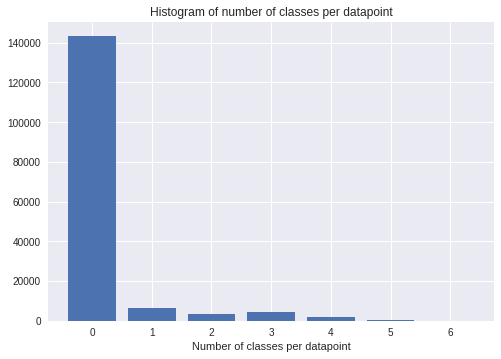

In [0]:
'''
Histogram of number of classes per datapoint
'''
labels, counts = np.unique(train_data_full_df[CLASSES].sum(axis=1), return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_title('Histogram of number of classes per comment')
plt.gca().set_xlabel('Number of classes per comment')
plt.gca().set_xticks(labels)
plt.show()



In [33]:
'''
Number of records per class type
'''
df_toxic = train_data_full_df.drop(['id', 'comment_text'], axis=1)
counts = []
categories = list(df_toxic.columns.values)
for i in categories: counts.append((i, df_toxic[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats



,category,number_of_comments
0,toxic,15294
1,severe_toxic,1595
2,obscene,8449
3,threat,478
4,insult,7877
5,identity_hate,1405


Text(0.5,0,'category')

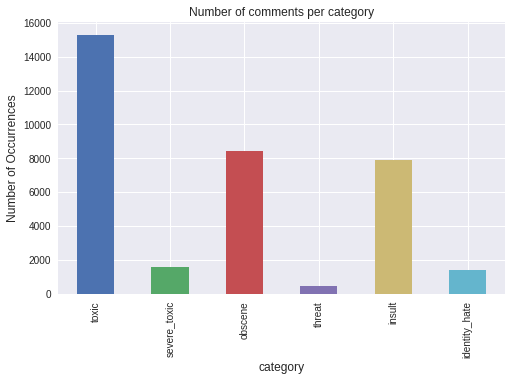

In [34]:
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title('Number of comments per category')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)


In [0]:
print('Percentage of comments that are not labelled:')
print(len(train_data_full_df[(train_data_full_df['toxic']==0) & (train_data_full_df['severe_toxic']==0) & (train_data_full_df['obscene']==0) & (train_data_full_df['threat']== 0) & (train_data_full_df['insult']==0) & (train_data_full_df['identity_hate']==0)]) / len(train_data_full_df))


Percentage of comments that are not labelled:
0.8983211235124177


'\nMost of the comment text length are within 500 characters\nSome outliers up to 4,000+ characters long.\n'

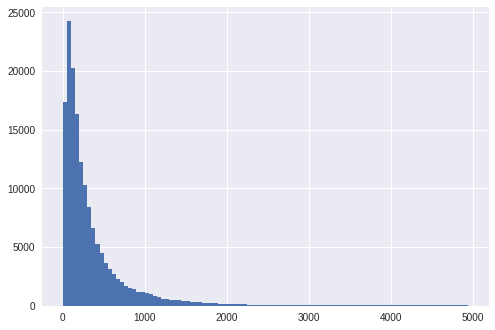

In [44]:
'''
#words in comment texts
'''

comment_length = train_data_full_df.comment_text.str.len()
comment_length.hist(bins = np.arange(0,5000,50))

'''
Most of the comment text length are within 500 characters
Some outliers up to 4,000+ characters long.
'''


In [0]:
comment_length

In [46]:
comment_length.mean()

394.0732213246768

In [47]:
'''
missing comment in comment text column.
'''

print('Number of missing comments in training data:')
train_data_full_df['comment_text'].isnull().sum()


Number of missing comments in training data:


0

##**Data Preparation**

In [6]:
## shuffle and split the dataset stratified by the number of classifications of a data point
## for balancing across resulting modeling and evaluation datasets

#Parameters for StratifiedShuffleSplit
v_n_splits=10
v_train_size=0.8
v_test_size=0.2


print('\n Training and evaluation data building starts')
train_start_time = time.time()
sss = StratifiedShuffleSplit(n_splits=v_n_splits, train_size=v_train_size, test_size=v_test_size, random_state=0)
for train_index, test_index in sss.split(np.zeros(len(train_data_full_df)), train_data_full_df[CLASSES].sum(axis=1)): pass


train_data_modeling_df = train_data_full_df.iloc[train_index]
train_data_eval_df = train_data_full_df.iloc[test_index]


print('\n Training and evaluation data building ends - Time(Seconds) - %s'% int(time.time() - train_start_time))



 Training and evaluation data building starts

 Training and evaluation data building ends - Time(Seconds) - 0


##**Some basic data charecteristics of training and evaluation data prepared**

In [0]:
print('---------------- Training Data ----------------')
print('Number of records in Training data set: %d' %len(train_data_modeling_df))
for x in CLASSES: print('Number of records of type %s: %d' %(x, len(train_data_modeling_df[train_data_modeling_df[x]==1])))
#print('--------------------------------------------------------------')
print('---------------- Evaluation Data ----------------')
print('Number of records in Evaluation data set: %d' %len(train_data_eval_df))
for x in CLASSES: print('Number of records of type %s: %d' %(x, len(train_data_eval_df[train_data_eval_df[x]==1])))


---------------- Training Data ----------------
Number of records in Training data set: 127656
Number of records of type toxic: 12248
Number of records of type severe_toxic: 1265
Number of records of type obscene: 6748
Number of records of type threat: 374
Number of records of type insult: 6307
Number of records of type identity_hate: 1137
---------------- Evaluation Data ----------------
Number of records in Evaluation data set: 31915
Number of records of type toxic: 3046
Number of records of type severe_toxic: 330
Number of records of type obscene: 1701
Number of records of type threat: 104
Number of records of type insult: 1570
Number of records of type identity_hate: 268


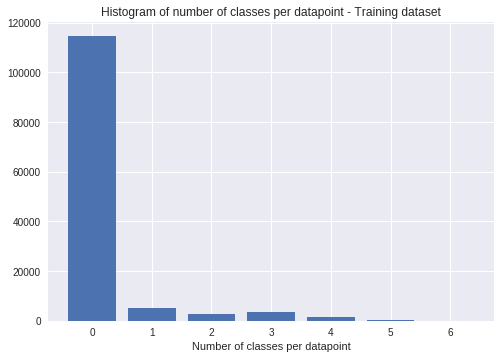

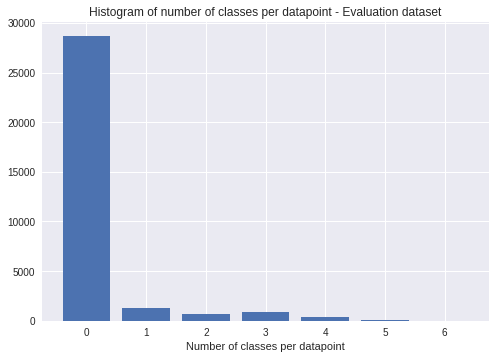

In [0]:
'''
Histogram of number of classes per datapoint for training and evaluation dataset
'''
labels, counts = np.unique(train_data_modeling_df[CLASSES].sum(axis=1), return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_title('Histogram of number of classes per datapoint - Training dataset')
plt.gca().set_xlabel('Number of classes per datapoint')
plt.gca().set_xticks(labels)
plt.show()

labels, counts = np.unique(train_data_eval_df[CLASSES].sum(axis=1), return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_title('Histogram of number of classes per datapoint - Evaluation dataset')
plt.gca().set_xlabel('Number of classes per datapoint')
plt.gca().set_xticks(labels)
plt.show()


'\nMost of the comment text length are within 500 characters\nSome outliers up to 4,000+ characters long.\n'

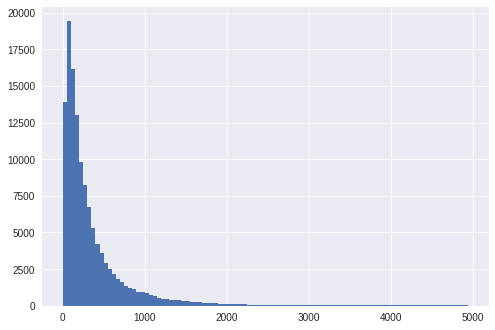

In [49]:
'''
#words in comment texts
'''

comment_length_moodel = train_data_modeling_df.comment_text.str.len()
comment_length_moodel.hist(bins = np.arange(0,5000,50))

'''
Most of the comment text length are within 500 characters
Some outliers up to 4,000+ characters long.


'''


'\nMost of the comment text length are within 500 characters\nSome outliers up to 4,000+ characters long.\n\n\n'

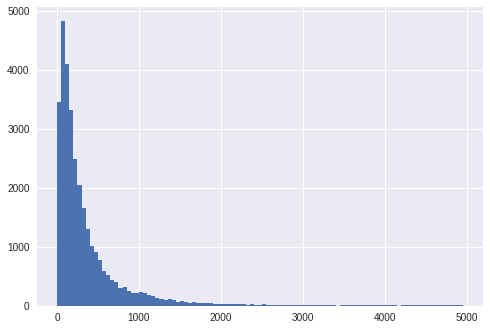

In [50]:
'''
#words in comment texts
'''

comment_length_moodel = train_data_eval_df.comment_text.str.len()
comment_length_moodel.hist(bins = np.arange(0,5000,50))

'''
Most of the comment text length are within 500 characters
Some outliers up to 4,000+ characters long.


'''


##**Embedding**

In [19]:
## doc2vec model from model training data
print('\n Building doc2vec model starts')
doc2vec_model1 = get_tfidf_vectorizer(train_data_modeling_df[TEXT_COLUMN])
doc2vec_model2 = get_nrange_tfidf_vectorizer(train_data_modeling_df[TEXT_COLUMN])
print('\n Building doc2vec model Ends')

## prepare the data vectors
print('\n Bullding vectors starts')
X = get_vectors(doc2vec_model1, doc2vec_model2, train_data_modeling_df[TEXT_COLUMN])
print('\n Bullding vectors ends')


 Building doc2vec model starts

 Building doc2vec model Ends

 Bullding vectors starts

 Bullding vectors ends


## Benchmark model

In [48]:
## LR
print('\n Building LR starts')

lr_start_time = time.time()


LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(max_features = 5000, stop_words='english',use_idf=True)),
                ('clf', OneVsRestClassifier(LogisticRegression(), n_jobs=-1)),
            ])

aucp=[]

for category in CLASSES:
    #print('Training {}'.format(category))
    print('\tTraining %s'%category)
    # train
    LogReg_pipeline.fit(train_data_modeling_df.comment_text, train_data_modeling_df[category])
    # predict
    prediction = LogReg_pipeline.predict(train_data_eval_df.comment_text)
    # Evaluate
    aucp.append(metrics.roc_auc_score(train_data_eval_df[category], prediction))
    #break


print('\t\tMean AUC Benchmark : %f' %np.mean(aucp))

print('\n Building LR ends - Time(Seconds) - %s'% int(time.time() - lr_start_time))



 Building LR starts
	Training toxic
	Training severe_toxic
	Training obscene
	Training threat
	Training insult
	Training identity_hate
		Mean AUC Benchmark : 0.700092

 Building LR ends - Time(Seconds) - 70


##**Project submission Model**

In [51]:
'''

Eval for pipeline model

'''

print('\t Creating pipeline model starts')

pm_start_time = time.time()

piperf = ExtendedMultiOutputClassifier(RandomForestClassifier(n_estimators = 100, n_jobs=-1))
pipemlp = MLPClassifier(solver='sgd', activation='logistic', learning_rate='adaptive', hidden_layer_sizes=(100, 100), random_state=1, momentum=0.9, alpha=1e-6)

pipm = Pipeline([('rf', piperf), ('nn', pipemlp)]) #--Pipeline 
pipm.fit(X, train_data_modeling_df[CLASSES])

print('\n Creating pipeline model starts ends - Time(Seconds) - %s'% int(time.time() - pm_start_time))

print('\t Predicting classes pipeline starts')
pred_start_time = time.time()
predicted_pipe = pipm.predict_proba(X_test)

predicted_pipeDf = pd.DataFrame(predicted_pipe)
predicted_pipeDf.columns = CLASSES

print('\n Predicting classes pipeline starts - Time(Seconds) - %s'% int(time.time() - pred_start_time))


print('\t Evaluating model ROC AUC pipeline\n')

# mean auc
aucs_pipeline = list(map(lambda klass: metrics.roc_auc_score(train_data_eval_df[klass], predicted_pipeDf[klass]), CLASSES))

print('\t\t-----------------------')
print('\t\t splits: %f' %v_n_splits)
print('\t\t train_size: %f' %v_train_size)
print('\t\t test_size: %f' %v_test_size)

print('\t\t Mean AUC pipeline: %f' %np.mean(aucs_pipeline))

print('\t\t-----------------------')

print('\t Evaluating model ROC AUC pipeline ends\n')


	 Creating pipeline model starts


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



 Creating pipeline model starts ends - Time(Seconds) - 1678
	 Predicting classes pipeline starts

 Predicting classes pipeline starts - Time(Seconds) - 18
	 Evaluating model ROC AUC pipeline

		-----------------------
		 splits: 10.000000
		 train_size: 0.800000
		 test_size: 0.200000
		 Mean AUC pipeline: 0.958547
		-----------------------
	 Evaluating model ROC AUC pipeline ends



In [52]:
X_test = get_vectors(doc2vec_model1, doc2vec_model2, train_data_eval_df[TEXT_COLUMN])


print('\t Predicting classes pipeline starts')
pred_start_time = time.time()
predicted_pipe = pipm.predict_proba(X_test)

predicted_pipeDf = pd.DataFrame(predicted_pipe)
predicted_pipeDf.columns = CLASSES

print('\n Predicting classes pipeline starts - Time(Seconds) - %s'% int(time.time() - pred_start_time))


print('\t Evaluating model ROC AUC pipeline\n')

# mean auc
aucs_pipeline = list(map(lambda klass: metrics.roc_auc_score(train_data_eval_df[klass], predicted_pipeDf[klass]), CLASSES))

print('\t\t-----------------------')
print('\t\t splits: %f' %v_n_splits)
print('\t\t train_size: %f' %v_train_size)
print('\t\t test_size: %f' %v_test_size)

print('\t\t Mean AUC pipeline: %f' %np.mean(aucs_pipeline))

print('\t\t-----------------------')

print('\t Evaluating model ROC AUC pipeline ends\n')



	 Predicting classes pipeline starts

 Predicting classes pipeline starts - Time(Seconds) - 17
	 Evaluating model ROC AUC pipeline

		-----------------------
		 splits: 10.000000
		 train_size: 0.800000
		 test_size: 0.200000
		 Mean AUC pipeline: 0.958547
		-----------------------
	 Evaluating model ROC AUC pipeline ends



##**Prediction and submission**

In [53]:
#Remove existing submission files
!rm -f submission.*
!ls -ltr submission.*

ls: cannot access 'submission.*': No such file or directory


In [54]:
'''
Test Data
'''
test_data = 'test.csv'
test_df = pd.read_csv(test_data)
test_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 2 columns):
id              153164 non-null object
comment_text    153164 non-null object
dtypes: object(2)
memory usage: 2.3+ MB


In [55]:
'''
With Pipeline
'''
print('\n Pipeline Prediction starts')
predict_start_time = time.time()

predX_sub = get_vectors(doc2vec_model1, doc2vec_model2, test_df[TEXT_COLUMN])
predy_sub = pipm.predict_proba(predX_sub)
predy_subdf = pd.DataFrame(data=predy_sub)


predy_subdf.columns = CLASSES
pipesubmission_file = 'submission_pipe.csv'
submit_df = pd.concat([test_df['id'], predy_subdf], axis=1)
submit_df.head()
submit_df.to_csv(pipesubmission_file, index=False)


print('\n Pipeline Prediction ends - Time(Seconds) - %s'% int(time.time() - predict_start_time))



 Pipeline Prediction starts

 Pipeline Prediction ends - Time(Seconds) - 116


In [56]:
#Count of records in submission file Should be 153165
!wc -l submission*.csv
#Zip the file
#!zip submission.zip submission.csv
!zip submission_pipe.zip submission_pipe.csv

153165 submission_pipe.csv
updating: submission_pipe.csv (deflated 70%)


In [0]:
#Download submission file
from google.colab import files
#files.download('submission.zip')
files.download('submission_pipe.zip')
